In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
import lime
from lime.lime_tabular import LimeTabularExplainer

/var/folders/xy/8mmbysx15_14yh_fwlh_2gdr0000gn/T/ipykernel_56602/629457616.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df = pd.read_csv('/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.replace('?',np.nan,inplace=True)
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [3]:

# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)
     
    

    


In [4]:
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())


def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

In [5]:

# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}


In [6]:
encounter_counts_diag1 = df['diag_1'].value_counts().reset_index()
encounter_counts_diag1.columns = ['ICD-9 Code', 'Number of Encounters']

In [7]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag1 = encounter_counts_diag1[encounter_counts_diag1['Number of Encounters'] > threshold]


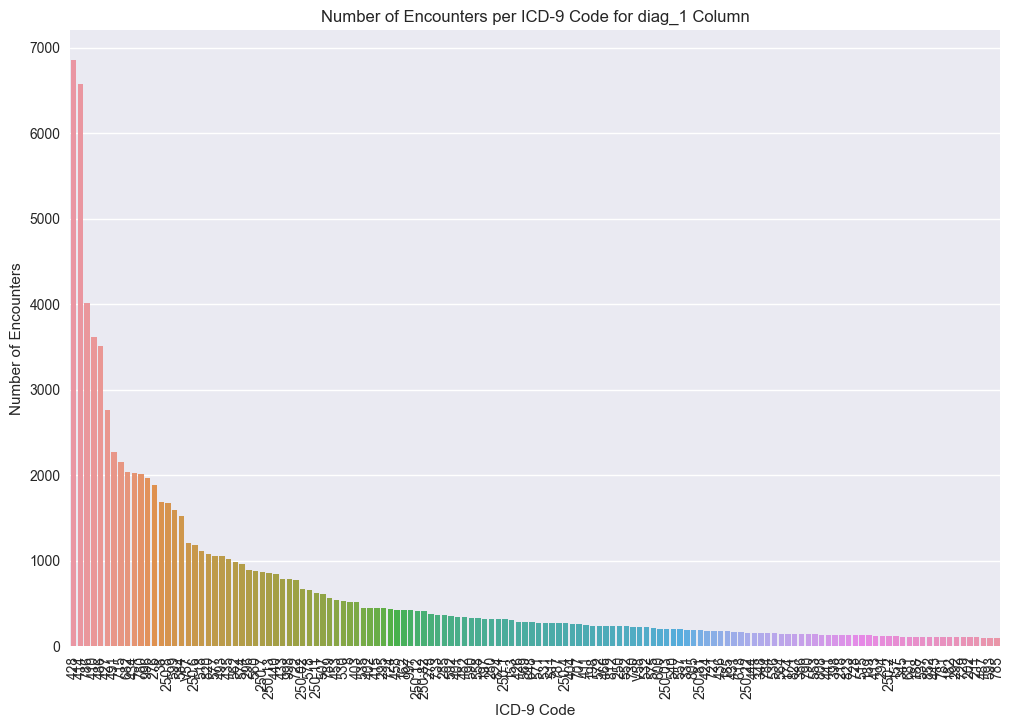

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag1, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_1 Column')
plt.show()


In [9]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes1 = encounter_counts_diag1.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_1'].isin(top_n_codes1)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values 'YES' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_1').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']



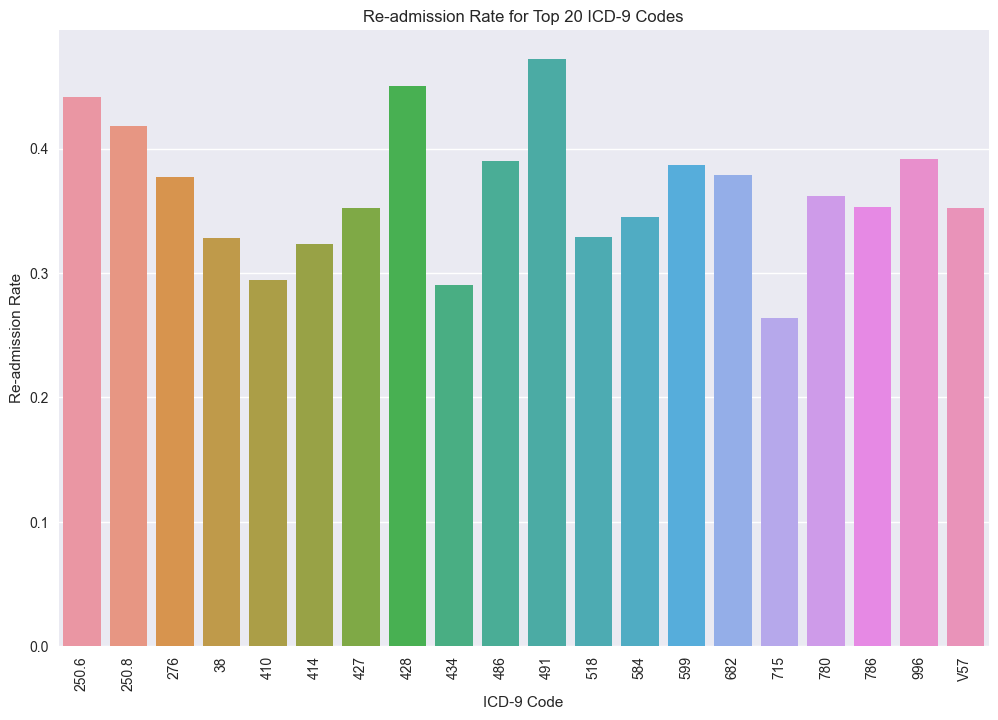

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()



In [11]:
encounter_counts_diag2 = df['diag_2'].value_counts().reset_index()
encounter_counts_diag2.columns = ['ICD-9 Code', 'Number of Encounters']

In [12]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag2 = encounter_counts_diag2[encounter_counts_diag2['Number of Encounters'] > threshold]

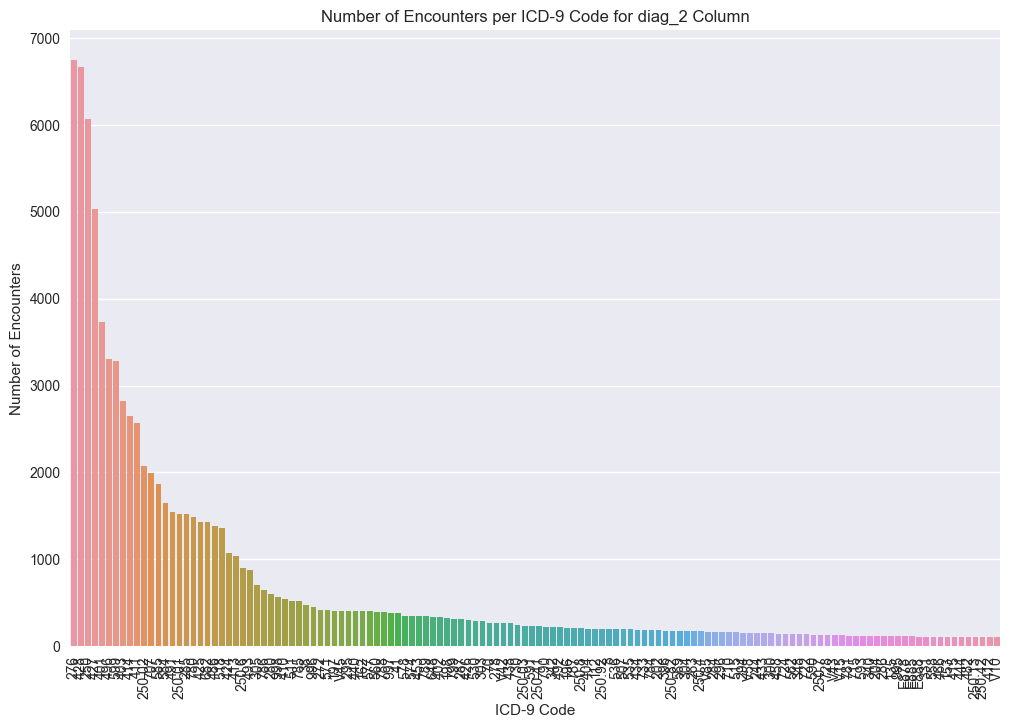

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag2, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_2 Column')
plt.show()


In [14]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes2 = encounter_counts_diag2.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_2'].isin(top_n_codes2)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values '>30' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_2').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']


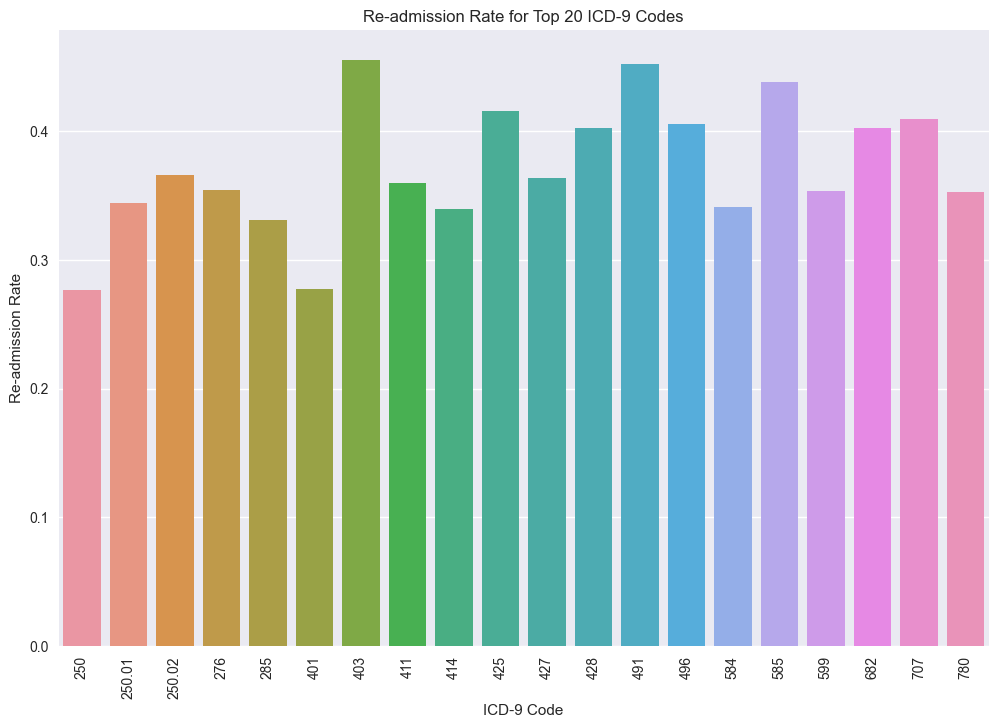

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()

In [16]:
encounter_counts_diag3 = df['diag_3'].value_counts().reset_index()
encounter_counts_diag3.columns = ['ICD-9 Code', 'Number of Encounters']

In [17]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag3 = encounter_counts_diag3[encounter_counts_diag3['Number of Encounters'] > threshold]

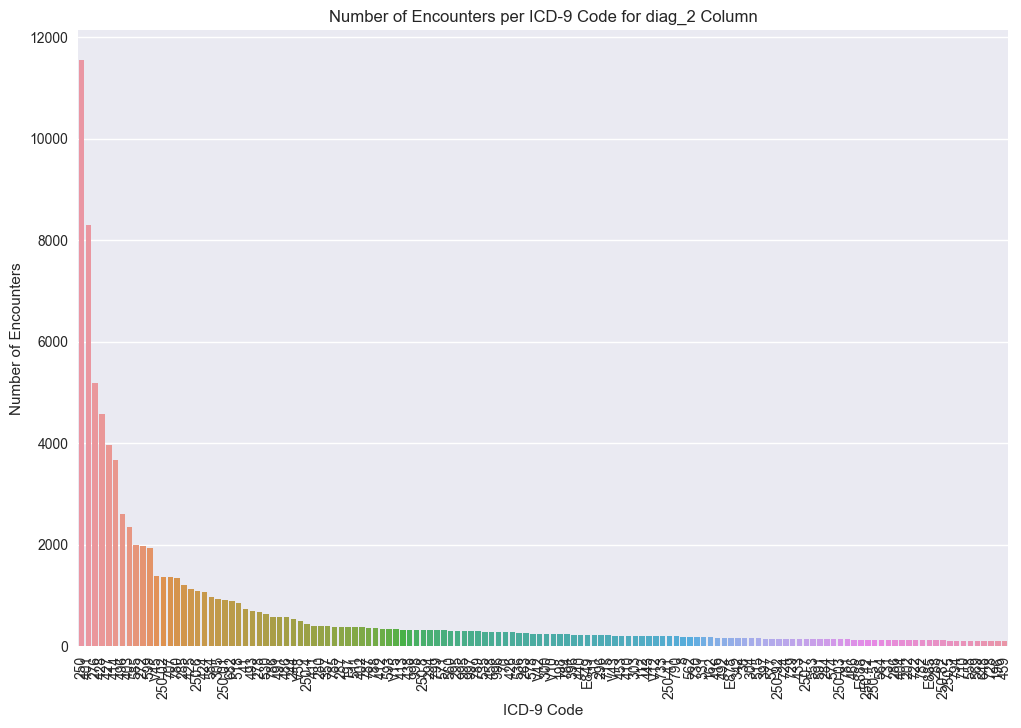

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag3, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_2 Column')
plt.show()


In [19]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes3 = encounter_counts_diag3.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_3'].isin(top_n_codes3)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values '>30' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_3').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']


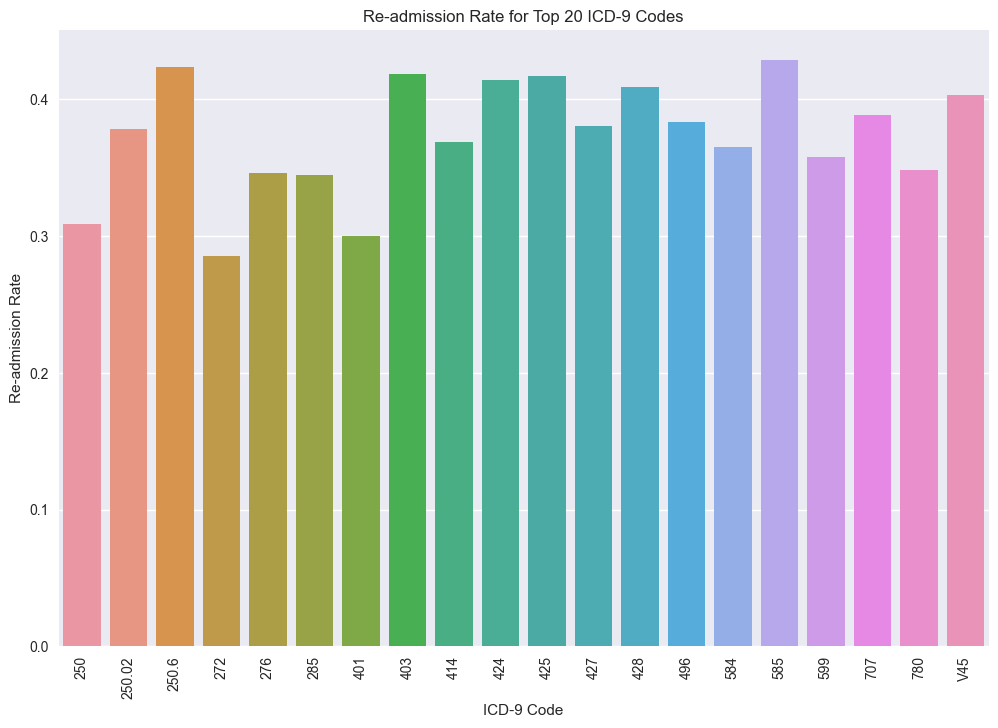

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()

In [21]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag1['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag1['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 142.10195530726256


In [22]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag2['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag2['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 135.57219251336898


In [23]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag3['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag3['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 127.17743979721166


In [24]:
# Combine all the codes into a single list
all_codes = top_n_codes1 + top_n_codes2 + top_n_codes3

# Convert the combined list into a set to get the unique codes
important_codes = list(set(all_codes))

# Print the unique important codes and their count
print(important_codes)
print("Total unique codes:", len(important_codes))


['780', '276', '707', '491', '585', '428', '250.01', '518', '584', '250', '250.6', '401', '403', '682', '285', '486', '715', '434', '250.8', '410', '996', '496', '250.02', '786', 'V57', 'V45', '425', '414', '272', '424', '411', '599', '427', '38']
Total unique codes: 34


In [25]:
# Ensure all diagnosis columns contain only the important codes
filtered_df = df[
    df['diag_1'].isin(important_codes) & 
    df['diag_2'].isin(important_codes) & 
    df['diag_3'].isin(important_codes)
]

# this dataframe consists only of the 42 most important ICD-9 codes

In [26]:
filtered_df

encounter_id  patient_nbr             race  gender      age weight  \
5              35754     82637451        Caucasian    Male  [50-60)    NaN   
6              55842     84259809        Caucasian    Male  [60-70)    NaN   
13             42570     77586282        Caucasian    Male  [80-90)    NaN   
16             77076     92519352  AfricanAmerican    Male  [50-60)    NaN   
20            150006     22864131              NaN  Female  [50-60)    NaN   
...              ...          ...              ...     ...      ...    ...   
101743     443793668     47293812        Caucasian    Male  [80-90)    NaN   
101744     443793992     43686936        Caucasian  Female  [80-90)    NaN   
101746     443797298     89955270        Caucasian    Male  [70-80)    NaN   
101749     443816024    106392411        Caucasian  Female  [70-80)    NaN   
101756     443842070    140199494            Other  Female  [60-70)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
5                       2                         1                    2   
6                       3                         1                    2   
13                      1                         6                    7   
16                      1                         1                    7   
20                      2                         1                    4   
...                   ...                       ...                  ...   
101743                  1                        13                    7   
101744                  1                         1                    7   
101746                  1                         1                    7   
101749                  3                         6                    1   
101756                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
5                      3  ...          No  Steady                   No   
6                      4  ...          No  Steady                   No   
13                    10  ...          No  Steady                   No   
16                     4  ...          No  Steady                   No   
20                     2  ...          No    Down                   No   
...                  ...  ...         ...     ...                  ...   
101743                 3  ...          No    Down                   No   
101744                 1  ...          No      No                   No   
101746                 4  ...          No      No                   No   
101749                 3  ...          No  Steady                   No   
101756                 2  ...          No  Steady                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
5                        No                        No   
6                        No                        No   
13                       No                        No   
16                       No                        No   
20                       No                        No   
...                     ...                       ...   
101743                   No                        No   
101744                   No                        No   
101746                   No                        No   
101749                   No                        No   
101756                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
5                            No                      No      No         Yes   
6                            No                      No      Ch         Yes   
13                           No                      No      No         Yes   
16                           No                      No      Ch         Yes   
20                           No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101743                       No

In [27]:
# Extract unique codes from each diagnosis column
unique_diag1 = filtered_df['diag_1'].unique().tolist()
unique_diag2 = filtered_df['diag_2'].unique().tolist()
unique_diag3 = filtered_df['diag_3'].unique().tolist()

# Combine the unique codes from the three columns
all_unique_codes_in_filtered_df = set(unique_diag1 + unique_diag2 + unique_diag3)

# Check if each code in the combined unique codes list is in the important_codes list
if all(code in important_codes for code in all_unique_codes_in_filtered_df):
    print("All codes in the filtered_df are from the important_codes list.")
else:
    unexpected_codes = [code for code in all_unique_codes_in_filtered_df if code not in important_codes]
    print("The following unexpected codes were found in the filtered_df:", unexpected_codes)


All codes in the filtered_df are from the important_codes list.


In [28]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29089 entries, 5 to 101756
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              29089 non-null  int64 
 1   patient_nbr               29089 non-null  int64 
 2   race                      28447 non-null  object
 3   gender                    29089 non-null  object
 4   age                       29089 non-null  object
 5   weight                    763 non-null    object
 6   admission_type_id         29089 non-null  int64 
 7   discharge_disposition_id  29089 non-null  int64 
 8   admission_source_id       29089 non-null  int64 
 9   time_in_hospital          29089 non-null  int64 
 10  payer_code                17223 non-null  object
 11  medical_specialty         14510 non-null  object
 12  num_lab_procedures        29089 non-null  int64 
 13  num_procedures            29089 non-null  int64 
 14  num_medications      

In [29]:
# Get the unique unexpected codes as discussed before
unique_diag1 = filtered_df['diag_1'].unique().tolist()
unique_diag2 = filtered_df['diag_2'].unique().tolist()
unique_diag3 = filtered_df['diag_3'].unique().tolist()

all_unique_codes_in_filtered_df = set(unique_diag1 + unique_diag2 + unique_diag3)
unexpected_codes = [code for code in all_unique_codes_in_filtered_df if code not in important_codes]

# Print the unexpected codes
print("Unexpected codes:", unexpected_codes)

# Display a few rows that contain these unexpected codes
sample_rows = filtered_df[filtered_df['diag_1'].isin(unexpected_codes) | 
                          filtered_df['diag_2'].isin(unexpected_codes) | 
                          filtered_df['diag_3'].isin(unexpected_codes)].head()

print(sample_rows)


Unexpected codes: []
Empty DataFrame
Columns: [encounter_id, patient_nbr, race, gender, age, weight, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, payer_code, medical_specialty, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, diag_1, diag_2, diag_3, number_diagnoses, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted]
Index: []

[0 rows x 50 columns]


In [30]:
filtered_df.describe()

encounter_id   patient_nbr  admission_type_id  \
count  2.908900e+04  2.908900e+04       29089.000000   
mean   1.627433e+08  5.414796e+07           1.992884   
std    1.011385e+08  3.852743e+07           1.465705   
min    3.575400e+04  1.305000e+03           1.000000   
25%    8.401738e+07  2.335349e+07           1.000000   
50%    1.510178e+08  4.494246e+07           1.000000   
75%    2.246536e+08  8.735301e+07           3.000000   
max    4.438421e+08  1.893659e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count              29089.000000         29089.000000      29089.000000   
mean                   3.776101             5.975386          4.172780   
std                    5.273308             4.012607          2.856075   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          3.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            22.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count        29089.000000    29089.000000     29089.000000       29089.000000   
mean            43.693080        1.497542        16.782254           0.387741   
std             19.483728        1.961049         8.552535           1.315758   
min              1.000000        0.000000         1.000000           0.000000   
25%             32.000000        0.000000        11.000000           0.000000   
50%             45.000000        1.000000        15.000000           0.000000   
75%             57.000000        3.000000        20.000000           0.000000   
max            129.000000        6.000000        81.000000          36.000000   

       number_emergency  number_inpatient  number_diagnoses  
count      29089.000000      29089.000000      29089.000000  
mean           0.164117          0.638420          7.546151  
std            0.649810          1.200976          1.821503  
min            0.000000          0.000000          3.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          9.000000  
75%            0.000000          1.000000          9.000000  
max           22.000000         16.000000         16.000000

In [31]:
filtered_df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                          642
gender                          0
age                             0
weight                      28326
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  11866
medical_specialty           14579
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [36]:
# Created another column and take it as 2 class problem, Label the <30 and >30 as YES and Other "N0" as No.

def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'
    
filtered_df['readmitted_2'] =filtered_df['readmitted'].apply(check_label) 

In [39]:
filtered_df.loc[filtered_df['race'] == '?', 'race'] = 'Other'

In [42]:
filtered_df['gender'].value_counts()

Female             14891
Male               14197
Unknown/Invalid        1
Name: gender, dtype: int64

In [43]:
filtered_df[filtered_df['gender']!='Unknown/Invalid']

encounter_id  patient_nbr             race  gender      age weight  \
5              35754     82637451        Caucasian    Male  [50-60)    NaN   
6              55842     84259809        Caucasian    Male  [60-70)    NaN   
13             42570     77586282        Caucasian    Male  [80-90)    NaN   
16             77076     92519352  AfricanAmerican    Male  [50-60)    NaN   
20            150006     22864131              NaN  Female  [50-60)    NaN   
...              ...          ...              ...     ...      ...    ...   
101743     443793668     47293812        Caucasian    Male  [80-90)    NaN   
101744     443793992     43686936        Caucasian  Female  [80-90)    NaN   
101746     443797298     89955270        Caucasian    Male  [70-80)    NaN   
101749     443816024    106392411        Caucasian  Female  [70-80)    NaN   
101756     443842070    140199494            Other  Female  [60-70)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
5                       2                         1                    2   
6                       3                         1                    2   
13                      1                         6                    7   
16                      1                         1                    7   
20                      2                         1                    4   
...                   ...                       ...                  ...   
101743                  1                        13                    7   
101744                  1                         1                    7   
101746                  1                         1                    7   
101749                  3                         6                    1   
101756                  1                         1                    7   

        time_in_hospital  ... insulin glyburide-metformin  \
5                      3  ...  Steady                  No   
6                      4  ...  Steady                  No   
13                    10  ...  Steady                  No   
16                     4  ...  Steady                  No   
20                     2  ...    Down                  No   
...                  ...  ...     ...                 ...   
101743                 3  ...    Down                  No   
101744                 1  ...      No                  No   
101746                 4  ...      No                  No   
101749                 3  ...  Steady                  No   
101756                 2  ...  Steady                  No   

        glipizide-metformin  glimepiride-pioglitazone  \
5                        No                        No   
6                        No                        No   
13                       No                        No   
16                       No                        No   
20                       No                        No   
...                     ...                       ...   
101743                   No                        No   
101744                   No                        No   
101746                   No                        No   
101749                   No                        No   
101756                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  \
5                            No                      No      No          Yes   
6                            No                      No      Ch          Yes   
13                           No                      No      No          Yes   
16                           No                      No      Ch          Yes   
20                           No                      No      Ch          Yes   
...                         ...                     ...     ...          ...   
101743                       No                      No      Ch          Yes   
101744                       No                      No      No           No   
101746              

In [44]:
# Drop the "Unknown/Invalid" gender of the data.
filtered_df.drop(filtered_df[filtered_df['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [45]:
filtered_df.reset_index(inplace = True, drop = True)

In [46]:
filtered_df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0         35754     82637451        Caucasian    Male  [50-60)    NaN   
1         55842     84259809        Caucasian    Male  [60-70)    NaN   
2         42570     77586282        Caucasian    Male  [80-90)    NaN   
3         77076     92519352  AfricanAmerican    Male  [50-60)    NaN   
4        150006     22864131              NaN  Female  [50-60)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  2                         1                    2   
1                  3                         1                    2   
2                  1                         6                    7   
3                  1                         1                    7   
4                  2                         1                    4   

   time_in_hospital  ... insulin glyburide-metformin  glipizide-metformin  \
0                 3  ...  Steady                  No                   No   
1                 4  ...  Steady                  No                   No   
2                10  ...  Steady                  No                   No   
3                 4  ...  Steady                  No                   No   
4                 2  ...    Down                  No                   No   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                        No                       No                      No   
1                        No                       No                      No   
2                        No                       No                      No   
3                        No                       No                      No   
4                        No                       No                      No   

   change  diabetesMed readmitted readmitted_2  
0      No          Yes        >30          Yes  
1      Ch          Yes         NO           No  
2      No          Yes         NO           No  
3      Ch          Yes        <30          Yes  
4      Ch          Yes         NO           No  

[5 rows x 51 columns]

In [47]:
# Check the distribution of 'race' groups
race_distribution = filtered_df['race'].value_counts()
print("Race distribution:\n", race_distribution)

Race distribution:
 Caucasian          22467
AfricanAmerican     4908
Hispanic             491
Other                420
Asian                160
Name: race, dtype: int64


In [52]:
# Lets drop this column. 
filtered_df.drop(columns = ['weight'], inplace = True)

In [57]:
filtered_df.drop(columns = ['payer_code'], inplace = True)

In [59]:
filtered_df.drop(columns =['medical_specialty'], inplace = True)

In [60]:
filtered_df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [61]:
filtered_df.shape

(29088, 38)

In [62]:
# Make copy of data.
filtered_df_ = filtered_df.copy()

In [63]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [64]:
categorical_features =['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    filtered_df_[i] = le.fit_transform(filtered_df_[i])

In [65]:
filtered_df_.head()

encounter_id  patient_nbr  race  gender  age  admission_type_id  \
0         35754     82637451     2       1    4                  1   
1         55842     84259809     2       1    5                  2   
2         42570     77586282     2       1    7                  0   
3         77076     92519352     0       1    4                  0   
4        150006     22864131     5       0    4                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                         0                    1                 3   
1                         0                    1                 4   
2                         5                    6                10   
3                         0                    6                 4   
4                         0                    3                 2   

   num_lab_procedures  ...  pioglitazone  rosiglitazone  acarbose  miglitol  \
0                  31  ...             1              1         0         0   
1                  70  ...             1              1         0         0   
2                  55  ...             1              1         0         0   
3                  45  ...             1              1         0         0   
4                  66  ...             1              1         0         0   

   insulin  glyburide-metformin  change  diabetesMed  readmitted  readmitted_2  
0        2                    0       1            1         >30           Yes  
1        2                    0       0            1          NO            No  
2        2                    0       1            1          NO            No  
3        2                    0       0            1         <30           Yes  
4        0                    0       0            1          NO            No  

[5 rows x 38 columns]

In [66]:
label = le.fit(filtered_df_['readmitted_2'])

In [67]:
filtered_df_['readmitted_2_encoded'] = label.transform(filtered_df_['readmitted_2'])

In [68]:
filtered_df_ = filtered_df_.drop(columns= ['encounter_id', 'patient_nbr', 'readmitted','readmitted_2'])

In [69]:
filtered_df_

race  gender  age  admission_type_id  discharge_disposition_id  \
0         2       1    4                  1                         0   
1         2       1    5                  2                         0   
2         2       1    7                  0                         5   
3         0       1    4                  0                         0   
4         5       0    4                  1                         0   
...     ...     ...  ...                ...                       ...   
29083     2       1    7                  0                        11   
29084     2       0    7                  0                         0   
29085     2       1    6                  0                         0   
29086     2       0    6                  2                         5   
29087     4       0    5                  0                         0   

       admission_source_id  time_in_hospital  num_lab_procedures  \
0                        1                 3                  31   
1                        1                 4                  70   
2                        6                10                  55   
3                        6                 4                  45   
4                        3                 2                  66   
...                    ...               ...                 ...   
29083                    6                 3                  45   
29084                    6                 1                  49   
29085                    6                 4                   2   
29086                    0                 3                  27   
29087                    6                 2                  46   

       num_procedures  num_medications  ...  glyburide  pioglitazone  \
0                   6               16  ...          1             1   
1                   1               21  ...          1             1   
2                   1               31  ...          1             1   
3                   4               17  ...          1             1   
4                   1               19  ...          1             1   
...               ...              ...  ...        ...           ...   
29083               0               26  ...          3             1   
29084               0               12  ...          1             1   
29085               0                7  ...          1             1   
29086               1               29  ...          1             1   
29087               6               17  ...          1             1   

       rosiglitazone  acarbose  miglitol  insulin  glyburide-metformin  \
0                  1         0         0        2                    0   
1                  1         0         0        2                    0   
2                  1         0         0        2                    0   
3                  1         0         0        2                    0   
4                  1         0         0        0                    0   
...              ...       ...       ...      ...                  ...   
29083              2         0         0        0                    0   
29084              1         0         0        1                    0   
29085              1         0         0        1                    0   
29086              1         0         0        2                    0   
29087              1         0         0        2                    0   

       change  diabetesMed  readmitted_2_encoded  
0           1            1                     1  
1           0            1                     0  
2           1            1                     0  
3           0            1                     1  
4           0            1                     0  
...       ...          ...                   ...  
29083       0            1                     0  
29084       1            0                     0  
29085       1            1                     1  
29086       0            1                     0 

In [70]:
# Check the distribution of 'race' groups
race_distribution = filtered_df_['race'].value_counts()
print("Race distribution:\n", race_distribution)

Race distribution:
 2    22467
0     4908
5      642
3      491
4      420
1      160
Name: race, dtype: int64


In [71]:
filtered_df_ = filtered_df_[filtered_df_['race'] != 5]

In [72]:
filtered_df_[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']].corr()

time_in_hospital  num_lab_procedures  num_procedures  \
time_in_hospital            1.000000            0.361372        0.138469   
num_lab_procedures          0.361372            1.000000        0.063483   
num_procedures              0.138469            0.063483        1.000000   
num_medications             0.492682            0.296469        0.369311   
number_outpatient           0.002334            0.012824       -0.057084   
number_emergency           -0.002166           -0.001408       -0.055288   
number_inpatient            0.072390            0.040381       -0.102262   
number_diagnoses            0.231089            0.153773       -0.024610   

                    num_medications  number_outpatient  number_emergency  \
time_in_hospital           0.492682           0.002334         -0.002166   
num_lab_procedures         0.296469           0.012824         -0.001408   
num_procedures             0.369311          -0.057084         -0.055288   
num_medications            1.000000           0.042910          0.022931   
number_outpatient          0.042910           1.000000          0.094296   
number_emergency           0.022931           0.094296          1.000000   
number_inpatient           0.062135           0.109883          0.275855   
number_diagnoses           0.213088           0.107221          0.087112   

                    number_inpatient  number_diagnoses  
time_in_hospital            0.072390          0.231089  
num_lab_procedures          0.040381          0.153773  
num_procedures             -0.102262         -0.024610  
num_medications             0.062135          0.213088  
number_outpatient           0.109883          0.107221  
number_emergency            0.275855          0.087112  
number_inpatient            1.000000          0.142237  
number_diagnoses            0.142237          1.000000

In [73]:
filtered_df_.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted_2_encoded'],
      dtype='object')

In [74]:
X = filtered_df_.drop(columns= ['readmitted_2_encoded'])
y = filtered_df_['readmitted_2_encoded']
A = filtered_df_['race']

In [75]:
from sklearn import preprocessing
scaled_X = preprocessing.StandardScaler().fit_transform(X)

In [76]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.20, 
    random_state=42)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, A_train.shape , A_test.shape

((22756, 34), (5690, 34), (22756,), (5690,), (22756,), (5690,))

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf_bal_sub = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43, class_weight='balanced_subsample')


In [80]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize the Balanced Random Forest Classifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on your training data
brf.fit(X_train, y_train)

# Make predictions
y_pred = brf.predict(X_test)




In [81]:
rf_bal = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43, class_weight='balanced')


In [82]:
# set up model:
classifiers = [
               rf_bal_sub,
              brf,
              rf_bal]

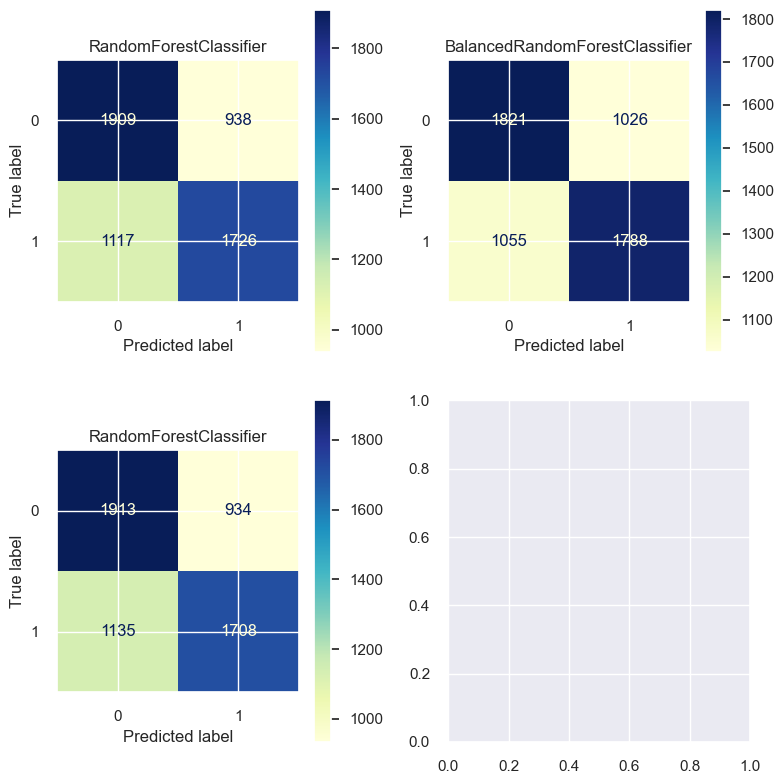

In [83]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

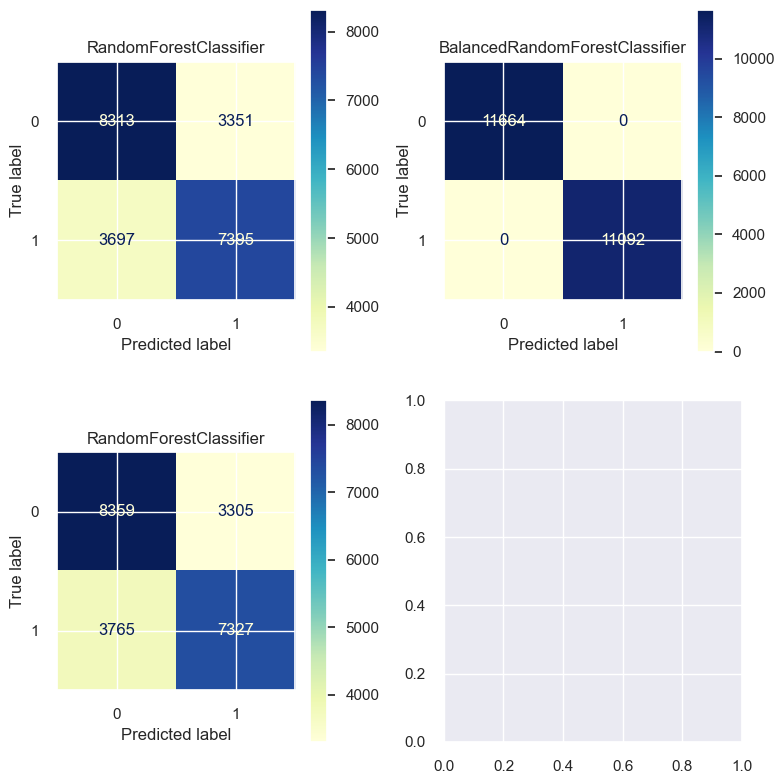

In [84]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [85]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}') 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      2847
           1       0.65      0.61      0.63      2843

    accuracy                           0.64      5690
   macro avg       0.64      0.64      0.64      5690
weighted avg       0.64      0.64      0.64      5690

BalancedRandomForestClassifier(random_state=42): 
               precision    recall  f1-score   support

           0       0.63      0.64      0.64      2847
           1       0.64      0.63      0.63      2843

    accuracy                           0.63      5690
   macro avg       0.63      0.63      0.63      5690
weighted avg       0.63      0.63      0.63      5690

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
               precision    recall  f1-sco

In [86]:
classification_report_aware = classification_report(y_test, y_pred)

In [87]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score



classifier_names = ["RF Balanced Subsample", "Balanced Random Forest", 'RF Balanced Sampling']

# Define the number of splits for cross-validation
n_splits = 4

# Loop over classifiers
for model, classifier_name in zip(classifiers, classifier_names):
    print(f"Evaluating {classifier_name}:")
    
    # Initialize lists to store classification reports and AUC scores
    classification_reports = []
    auc_scores = []
    
    # Perform cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=n_splits).split(X_test, y_test):
        X_train_cv, X_test_cv = X_test.iloc[train_index], X_test.iloc[test_index]
        y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]

        # Fit the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = model.predict(X_test_cv)

        # Predict probabilities for the 'Readmitted' class
        y_probs_cv = model.predict_proba(X_test_cv)[:, 1]

        # Compute the ROC-AUC score
        auc_cv = roc_auc_score(y_test_cv, y_probs_cv)
        auc_scores.append(auc_cv)

        # Generate and store the classification report
        report_cv = classification_report(y_test_cv, y_pred_cv, target_names=['Not Readmitted', 'Readmitted'], output_dict=True)
        classification_reports.append(report_cv)

    # Calculate the average AUC score across cross-validation folds
    avg_auc_score = sum(auc_scores) / len(auc_scores)
    
    # Calculate the average classification report across cross-validation folds
    avg_classification_report = {}
    for label in ['Not Readmitted', 'Readmitted']:
        avg_classification_report[label] = {
            'precision': sum(report[label]['precision'] for report in classification_reports) / len(classification_reports),
            'recall': sum(report[label]['recall'] for report in classification_reports) / len(classification_reports),
            'f1-score': sum(report[label]['f1-score'] for report in classification_reports) / len(classification_reports),
            'support': int(sum(report[label]['support'] for report in classification_reports) / len(classification_reports))
        }

    # Format and print the results
    print("Average Classification Report Aware of Race:")
    for label in avg_classification_report:
        print(f"{label}:")
        for metric in avg_classification_report[label]:
            print(f"{metric}: {avg_classification_report[label][metric]:.2f}")
        print()
    print(f"Average AUC Score: {avg_auc_score:.2f}")
    print("\n")

Evaluating RF Balanced Subsample:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.64
recall: 0.66
f1-score: 0.65
support: 711.00

Readmitted:
precision: 0.65
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating Balanced Random Forest:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.63
recall: 0.65
f1-score: 0.64
support: 711.00

Readmitted:
precision: 0.64
recall: 0.62
f1-score: 0.63
support: 710.00

Average AUC Score: 0.68


Evaluating RF Balanced Sampling:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.65
support: 711.00

Readmitted:
precision: 0.65
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69




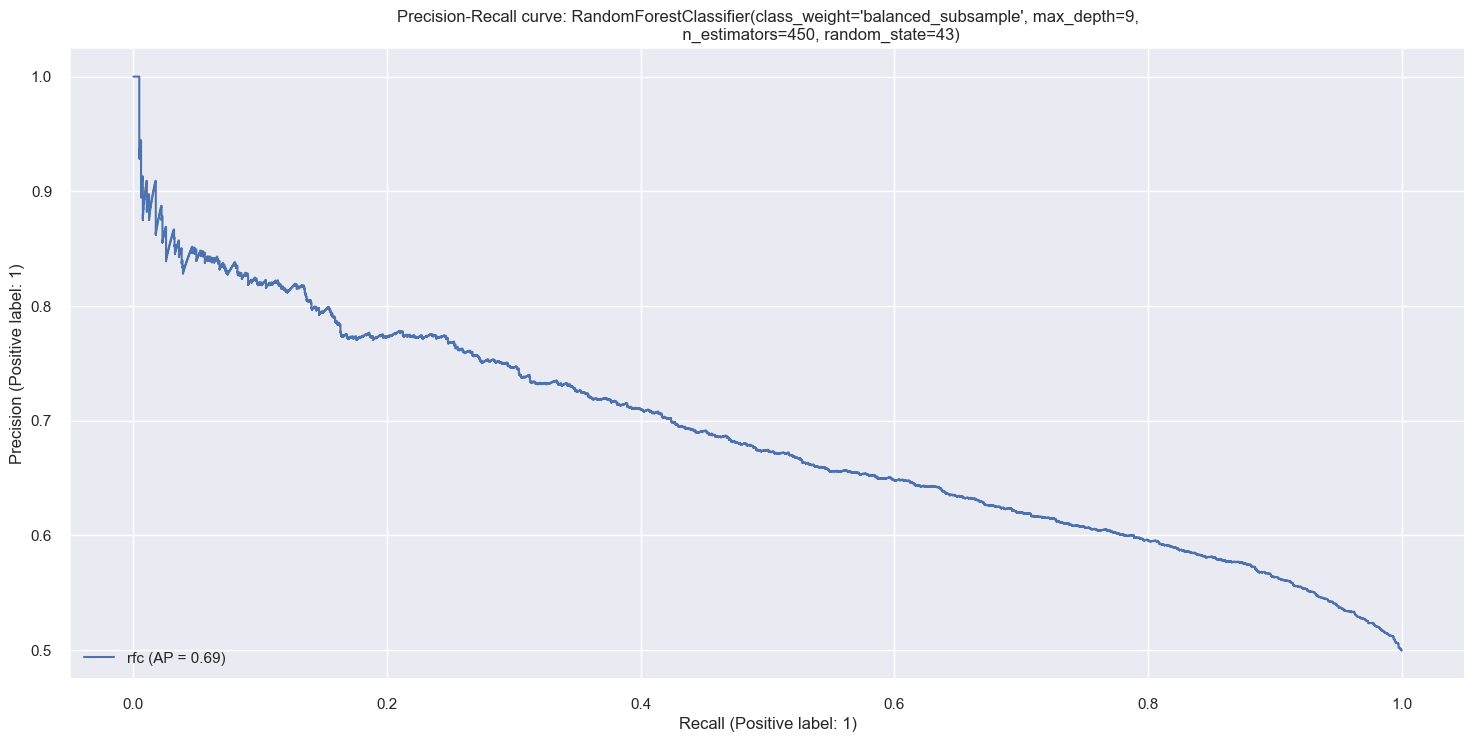

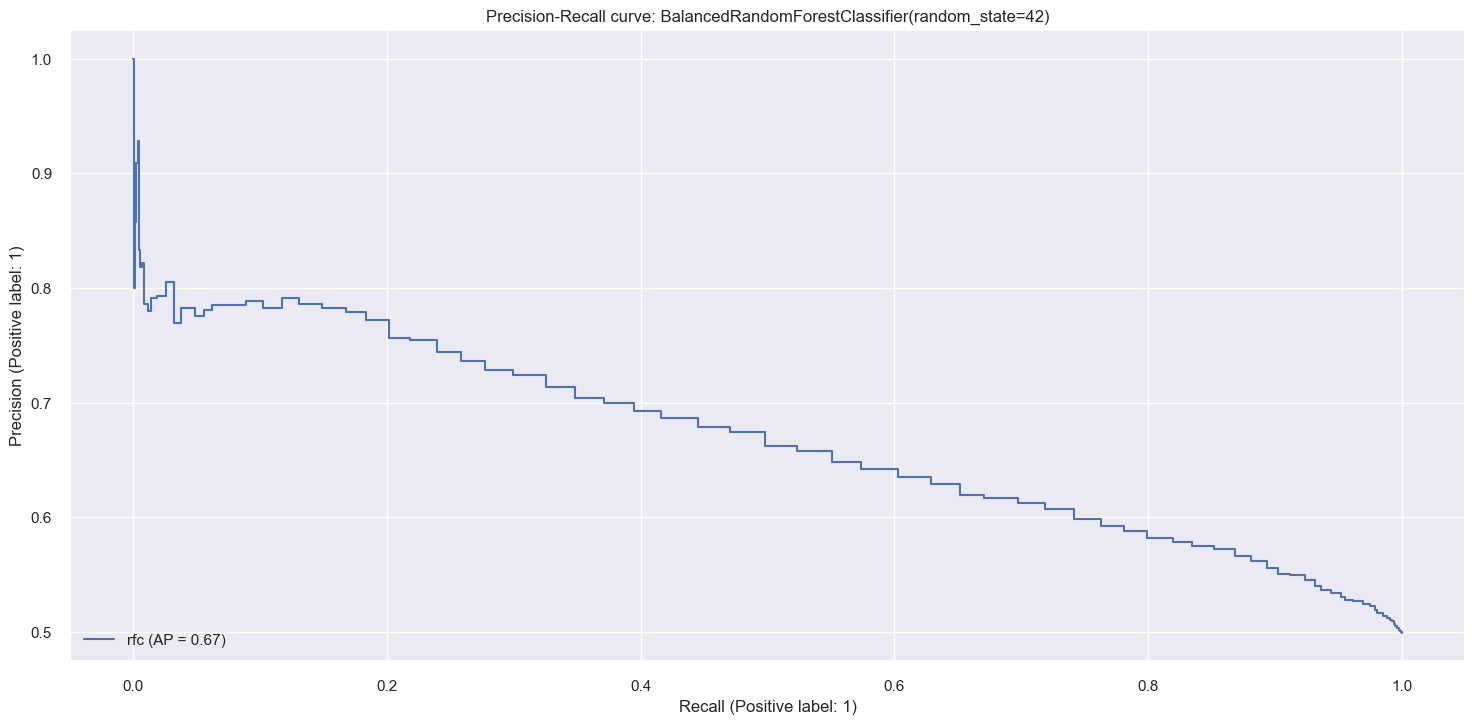

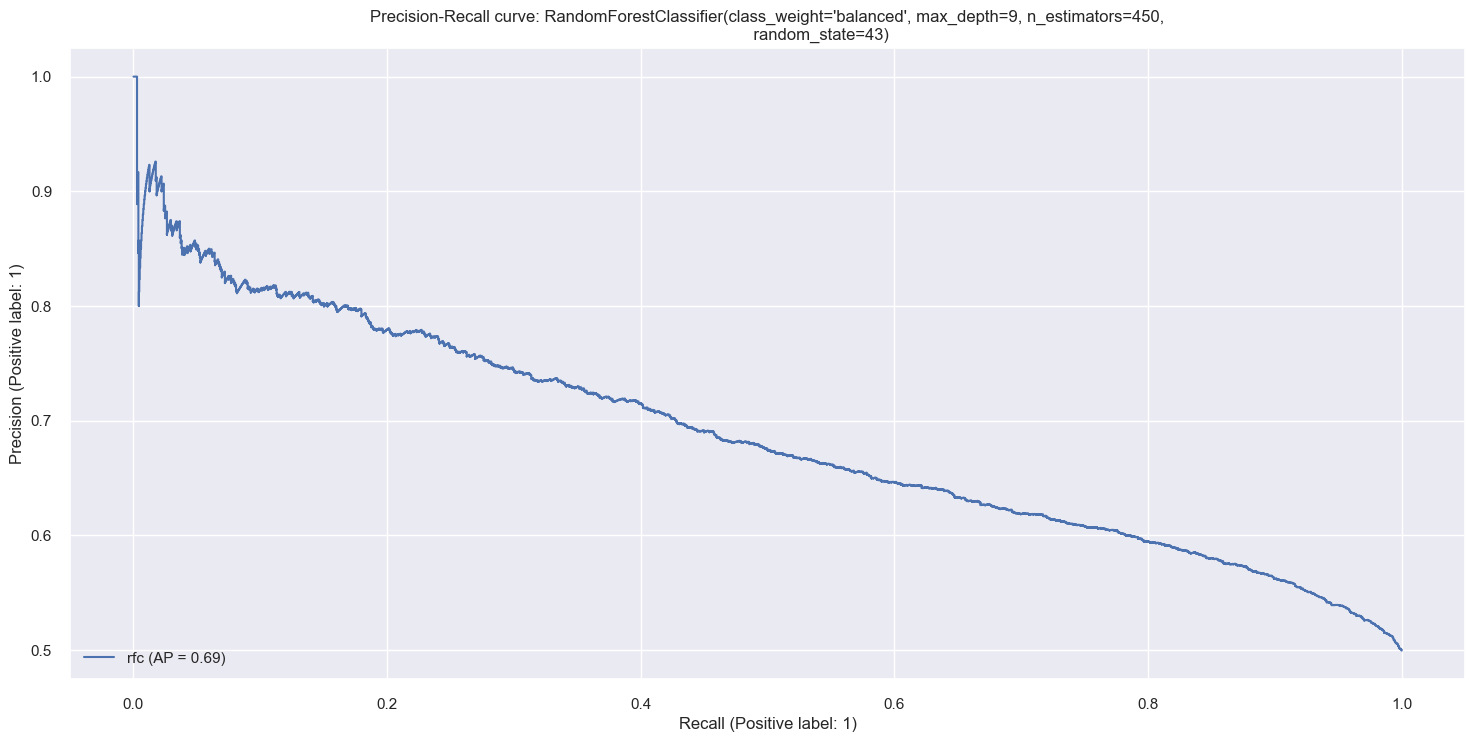

In [88]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')   

### The precision-recall curve for the Random Forest Classifier with balanced subsampling indicates a moderate trade-off between precision and recall. The curve starts with a high precision which gradually decreases as recall increases. This shows that the model initially makes very precise predictions, but as it attempts to cover more of the positive class (higher recall), its precision decreases.

### The behavior of the curve suggests that this model maintains a reasonable balance between precision and recall for a significant range before precision drops more noticeably. This is a desirable characteristic if the goal is to maintain a higher recall, as the precision does not drop precipitously.

### In my case, where high recall is a priority (wanting to catch as many positive cases as possible), this model seems promising as it maintains a better balance between precision and recall than the CatBoost model, which showed a steep decline in precision. The area under the curve (AP) for this model is 0.69, which is a good score, indicating that overall, the model has a good balance of precision and recall across different thresholds.

In [89]:
# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.324853  0.354086  0.645914  0.675147
1     0.250000  0.200000  0.800000  0.750000
2     0.399910  0.336311  0.663689  0.600090
3     0.285714  0.422222  0.577778  0.714286
4     0.292683  0.466667  0.533333  0.707317 

Race:
BalancedRandomForestClassifier(random_state=42): 
            FPR       FNR       TPR       TNR
race                                        
0     0.397260  0.348249  0.651751  0.602740
1     0.437500  0.200000  0.800000  0.562500
2     0.421053  0.322019  0.677981  0.578947
3     0.250000  0.400000  0.600000  0.750000
4     0.292683  0.533333  0.466667  0.707317 

Race:
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
            FPR       FNR       TPR       TN

### We observe that Class Weight = Balanced RF is the most balanced and accurate model in terms of TPR TNR accross all groups

In [90]:
# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Aware-Unmitigated": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2}')

# Calculate the overall Equal Opportunity Differences between races 1 and 2 and between races 3 and 2
eod_race1_and_2_avg = sum(difference_race1_and_2) / len(difference_race1_and_2)
eod_race3_and_2_avg = sum(difference_race3_and_2) / len(difference_race3_and_2)

# Print the average Equal Opportunity Differences
print(f'Average Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2_avg}')
print(f'Average Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2_avg}')



Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
                                Aware-Unmitigated
Equalized_odds_difference               0.266667
False negative rate difference          0.266667
Balanced error rate difference          0.154675
Demographic parity difference           0.137906
  ------                                        
Overall AUC                             0.696415
AUC difference                          0.157825 

Equal Opportunity Difference between Races Asian and Caucasian: -0.1363108530594016
Equal Opportunity Difference between Races Hispanic and Caucasian: 0.08591136916282072
Race:
BalancedRandomForestClassifier(random_state=42): 
                                Aware-Unmitigated
Equalized_odds_difference               0.333333
False negative rate difference          0.333333
Balanced error rate difference          0.094258
Demographic parity difference           0.24

### We can also observe the RF models with different class weight parameters are better than the Balanced RF classifier

In [93]:

# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [131]:
import lime
import lime.lime_tabular

In [132]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [133]:
j = 3000
exp = explainer.explain_instance(X_test.values[j], rf_bal.predict, num_features=15)

Intercept 1.5325084352826788
Prediction_local [-0.13955788]
Right: 0


### Random Instance - Caucasian Race - Race 2 affects positively the Y output of Random Forest 

In [134]:
# Show the predictions
exp.show_in_notebook(show_table=True)

In [135]:
exp.as_list()


[('number_inpatient <= 0.00', -0.59671146726632),
 ('number_outpatient <= 0.00', -0.3880823761529599),
 ('number_emergency <= 0.00', -0.30560961384318924),
 ('discharge_disposition_id > 4.00', -0.2612779549487781),
 ('miglitol <= 0.00', -0.1809146310944318),
 ('3.00 < number_diagnoses <= 6.00', 0.16018754853295072),
 ('glyburide-metformin <= 0.00', -0.05877456722932474),
 ('diag_3 <= 6.00', -0.051344546575950015),
 ('diag_2 <= 9.00', -0.0445043478755299),
 ('repaglinide <= 1.00', -0.03963261001773661),
 ('1.00 < num_procedures <= 3.00', -0.03735636328737694),
 ('A1Cresult <= 2.00', 0.03622917426151758),
 ('nateglinide <= 1.00', 0.03566565456168073),
 ('15.00 < num_medications <= 20.00', 0.03326456356598734),
 ('glimepiride <= 1.00', 0.026795221466376553)]

In [136]:
exp_lime_rf_bal = explainer.explain_instance(X_test.values[j], rf_bal.predict, num_features=15)

Intercept 1.4871662969348114
Prediction_local [-0.1623088]
Right: 0


### Random Instance - Caucasian Race - Race affects positively the Y output of XGBoost 

In [137]:
# Show the predictions
exp_lime_rf_bal.show_in_notebook(show_table=True)

In [144]:
import shap
import matplotlib.pyplot as plt

# Load JS visualization code to the notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(rf_bal)

shap_values = explainer.shap_values(X_test)

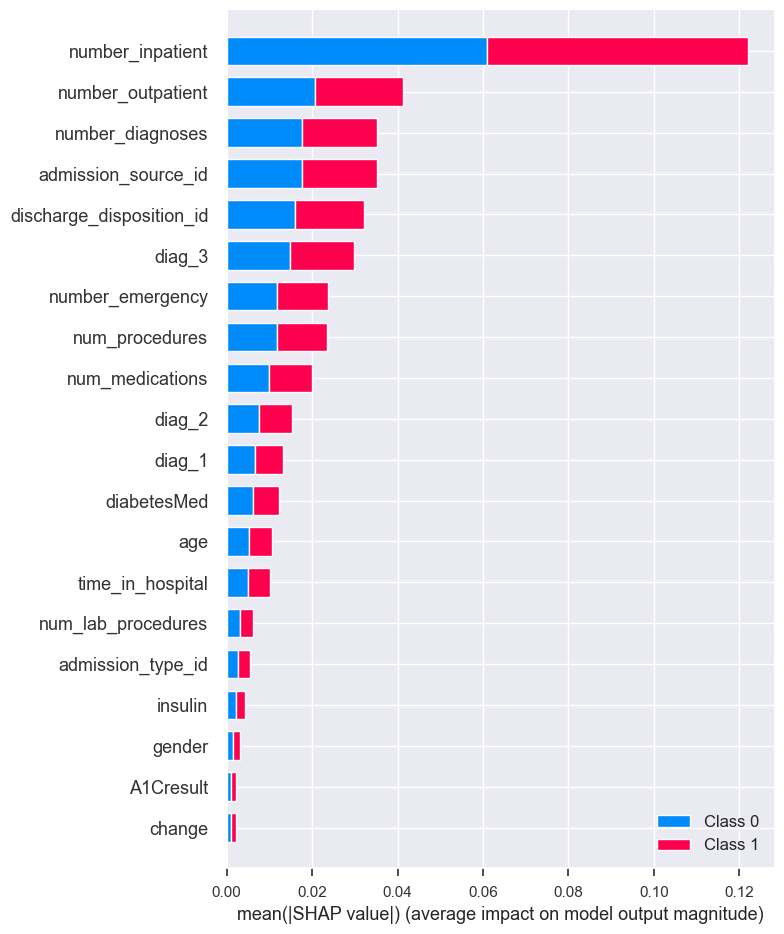

In [145]:
# Create a summary plot and set the feature names
shap.summary_plot(shap_values, X_test, show=False)

# Display the plot
plt.show()

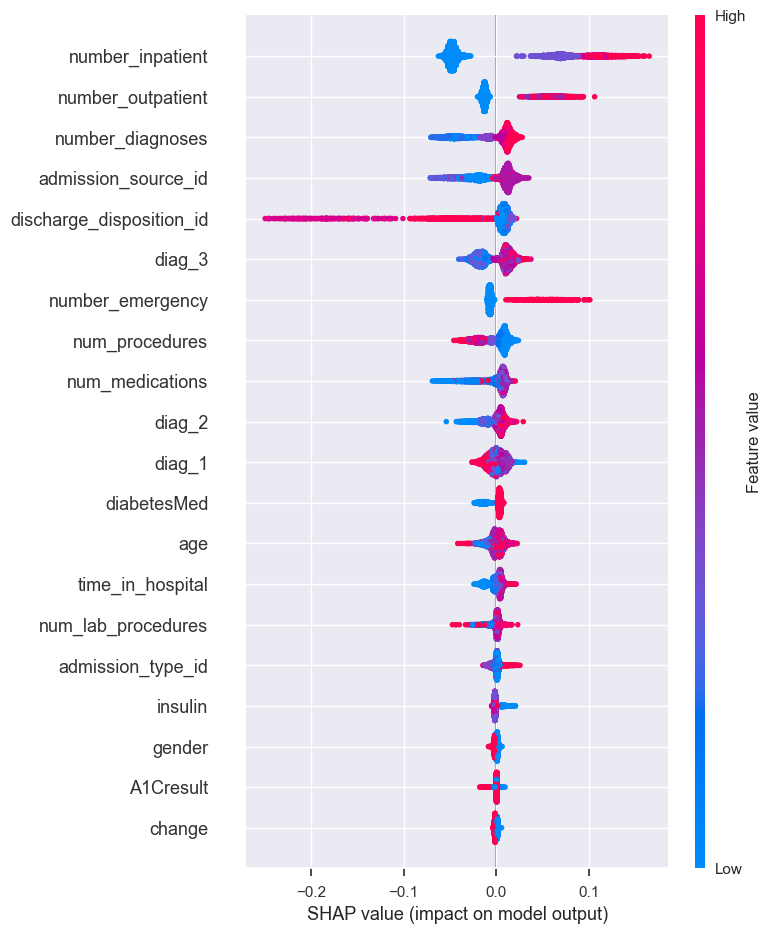

In [146]:
shap.summary_plot(shap_values[1], X_test)

### Top weights for each classifier, affecting the output

In [147]:
import eli5
eli5.show_weights(rf_bal, feature_names=X_train.columns.tolist())


In [154]:
import eli5
eli5.show_weights(rf_bal_sub, feature_names=X_train.columns.tolist())


In [155]:
import eli5
eli5.show_weights(brf, feature_names=X_train.columns.tolist())
